In [25]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PowerTransformer
from pystan import StanModel
from scipy.interpolate import splev
from fbprophet import Prophet
import pmdarima as pm
import itertools
import arviz as az

def RMSE(a, b):
    return mean_squared_error(a,b)**0.5

In [27]:
# power transformer

failure_df = pd.read_csv('failure_count.csv').set_index('age')
engine_df = pd.read_csv('engine.csv').set_index('ship')
test_failure_df = pd.read_csv('failure_count_test.csv').set_index('age')
test_engine_df = pd.read_csv('engine_test.csv').set_index('ship')

pt = PowerTransformer()
pt.fit(failure_df)
failure_df = pd.DataFrame(pt.transform(failure_df),index=failure_df.index, columns=failure_df.columns)
pt.fit(test_failure_df)
test_failure_df = pd.DataFrame(pt.transform(test_failure_df), index=test_failure_df.index, columns=test_failure_df.columns)

engine_df.engine.value_counts()

/Users/choibaroti/opt/anaconda3/envs/stan/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


3    43
2    27
4    19
1     6
5     4
Name: engine, dtype: int64

In [28]:
# failure_df = pd.read_csv('failure_count.csv').set_index('age')
# u = np.nanmean(failure_df.values.flatten())
# s = np.sqrt(np.nanvar(failure_df.values.flatten()))
# failure_df = pd.DataFrame((failure_df - u) / s, index=failure_df.index, columns=failure_df.columns)
# engine_df = pd.read_csv('engine.csv').set_index('ship')


# # plt.hist(pt.transform((failure_df.values[~np.isnan(failure_df)].reshape(-1, 1))), bins=20)
# # # plt.show()
# # plt.hist(failure2_df.values[~np.isnan(failure_df)].reshape(-1, 1), bins=20)
# # # plt.show()

# test_failure_df = pd.read_csv('failure_count_test.csv').set_index('age')
# test_failure_df = pd.DataFrame((test_failure_df - u) / s, index=test_failure_df.index, columns=test_failure_df.columns)
# test_engine_df = pd.read_csv('engine_test.csv').set_index('ship')

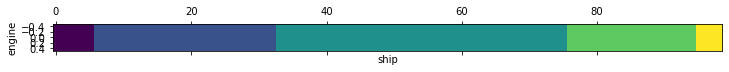

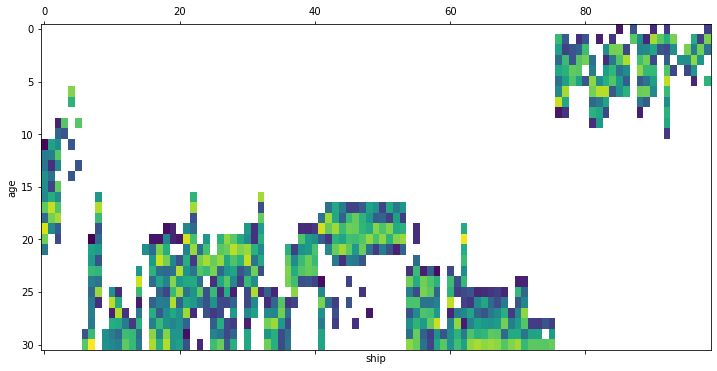

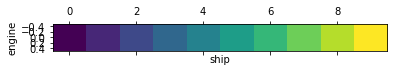

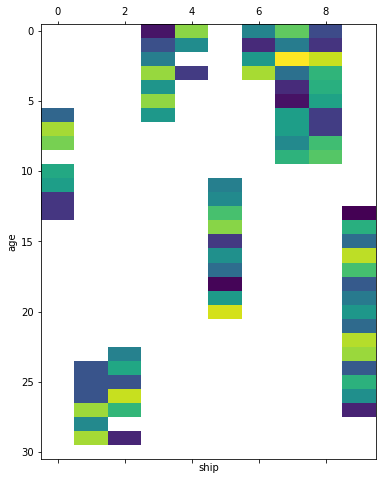

In [29]:
fig, ax = plt.subplots(figsize=(12, 0.5))
ax.set_xlabel('ship')
ax.set_ylabel('engine')
ax.matshow(engine_df.transpose(), aspect = 'auto')

plt.savefig('data.png', dpi=400)    
plt.show()

fig, ax = plt.subplots(figsize=(12, 6))
ax.set_xlabel('ship')
ax.set_ylabel('age')
ax.matshow(failure_df,aspect = 'auto')
plt.savefig('data2.png', dpi=400)    

plt.show()

fig, ax = plt.subplots(figsize=(6, 0.5))
ax.set_xlabel('ship')
ax.set_ylabel('engine')
ax.matshow(test_engine_df.transpose(),aspect = 'auto')
plt.savefig('data3.png', dpi=400)    

plt.show()


fig, ax = plt.subplots(figsize=(6, 8))
ax.set_xlabel('ship')
ax.set_ylabel('age')
ax.matshow(test_failure_df,aspect = 'auto')
plt.savefig('data4.png', dpi=400)    

plt.show()




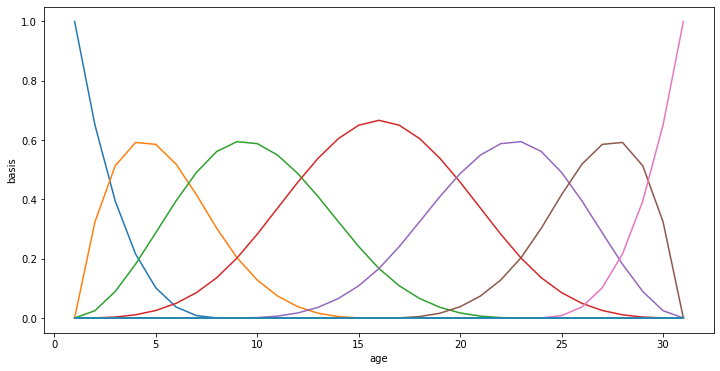

In [30]:
degree = 3
knots = np.linspace(1, 31, num=5)
knots_padded = np.concatenate((np.full(degree, 1), knots, np.full(degree, 31)))

basis = []
for i in range(knots_padded.shape[0]):
    c = np.zeros(knots_padded.shape[0])
    c[i] = 1
    basis.append(splev(np.arange(1, 32), (knots_padded, c, degree)))
basis_df = pd.DataFrame(basis).transpose().set_index(np.arange(1, 32))

fig, ax = plt.subplots(figsize=(12, 6))
ax.set_xlabel('age')
ax.set_ylabel('basis')
basis_df.plot(ax=ax, legend=False)

In [146]:
model_code ='''
data {
    int<lower=1> K; // number of knots
    int<lower=1> N; // number of datapoints
    int<lower=1> T; // maximum age
    int<lower=1> S; // number of ships
    int<lower=1> E; // number of engines
    int<lower=1> age[N];
    int<lower=1> ship[N];
    int<lower=1> engine[S];
    matrix[T,K] B;
    vector[N] Y;
}

parameters {
    // first layer
    real mu_alpha_bar;
    real<lower=0> sigma_alpha_bar;
    vector[K] mu_w_bar;
    real<lower=0> sigma_w_bar;

    // second layer
    real alpha_bar[E];
    real<lower=0> sigma_alpha;
    vector[K] w_bar[E];
    real<lower=0> sigma_w;

    // third layer
    real alpha[S];
    vector[K] w[S];
    real<lower=0> sigma_y;
}

transformed parameters { 
    vector[N] mu;
    for (n in 1:N) {
        mu[n] = alpha[ship[n]] + B[age[n]] * w[ship[n]];
    }
}

model {
    mu_alpha_bar ~ normal(0, 1);
    mu_w_bar ~ normal(0, 1);
    sigma_alpha_bar ~ exponential(1);
    sigma_w_bar ~ exponential(1);

    for (e in 1:E) {
        alpha_bar[e] ~ normal(mu_alpha_bar, sigma_alpha_bar);
        w_bar[e] ~ normal(mu_w_bar, sigma_w_bar);
    }
    sigma_alpha ~ gamma(15000,2);
    sigma_w ~ gamma(15000,2);

    for (s in 1:S) {
        alpha[s] ~ normal(alpha_bar[engine[s]], sigma_alpha);
        w[s] ~ normal(w_bar[engine[s]], sigma_w);
    }
    sigma_y ~ exponential(1);
    
    Y ~ normal(mu, sigma_y);
}

generated quantities{
    vector[N] log_likelihood;
    for (n in 1:N) {
        log_likelihood[n] = normal_lpdf(Y[n]|mu[n], sigma_y);
    }
}
'''

In [147]:
sm = StanModel(model_code=model_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_ad0f2a516159bcd503403d8198ece847 NOW.


In [148]:
failure_df.values[~failure_df.isnull()].shape[0]

653

In [149]:
K = basis_df.shape[1]
T = 31
S = failure_df.shape[1]
E = np.unique(engine_df['engine']).shape[0]
Y = failure_df.values[~failure_df.isnull()]
# Y = pt.fit(failure_df.values[~np.isnan(failure_df)].reshape(-1, 1))
# Y = np.concatenate((ptpt), axis=None)
age_index, ship_index = np.where(~failure_df.isnull())

data = {
    'K' : K,
    'N' : Y.shape[0],
#     'N' : failure_df.values[~failure_df.isnull()].shape[0],
    'T' : T,
    'S' : S,
    'E' : E,
    'age': age_index + 1,
    'ship': ship_index + 1,
    'engine': engine_df.loc[failure_df.columns, 'engine'],
    'Y': Y,
    'B': basis_df,
}

fit = sm.sampling(data=data)
fit_df = fit.to_dataframe().mean()

samples = fit.extract()

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f83d91cc750>],
      dtype=object)

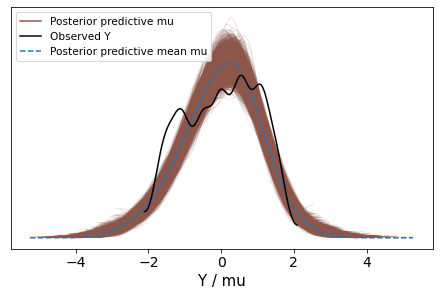

In [150]:
aaa = az.from_pystan(posterior=fit, posterior_predictive="mu", observed_data="Y")
az.plot_ppc(aaa, data_pairs={"Y": "mu"})

In [196]:
fit


For the full summary use 'print(fit)'

Inference for Stan model: anon_model_ad0f2a516159bcd503403d8198ece847.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                   mean se_mean     sd   2.5%    25%     50%    75%  97.5%  n_eff   Rhat
mu_alpha_bar       0.59    0.14   0.67  -1.01   0.23    0.74   1.08   1.53     22   1.19
sigma_alpha_bar    0.82    0.35   0.87   0.03   0.19    0.53    1.1   3.32      6    1.4
mu_w_bar[1]       -0.44    0.21   0.67  -1.66  -0.93   -0.49  -0.01   1.01     10   1.32
mu_w_bar[2]        0.55    0.63   1.14  -1.78  -0.35     0.8   1.48   2.42      3   1.93
mu_w_bar[3]       -0.24    0.16   0.73  -1.66  -0.72   -0.26   0.25   1.18     21   1.22
mu_w_bar[4]        0.28    0.59   1.04  -1.49  -0.49    0.12   1.01   2.51      3   1.98
mu_w_bar[5]        0.32    0.35   0.98  -1.56   -0.3    0.23   1.04   2.28      8   1.69
mu_w_bar[6]        0.18    0.77   1.28  -1.89  -0.88    0.0

[[(0, 1), 0.1116669112064567],
 [(0, 2), 0.09767844578831711],
 [(0, 3), 0.057482588158472535],
 [(0, 4), 0.04198225300265305],
 [(1, 2), 0.20547480842359805],
 [(1, 3), 0.10841348611169453],
 [(1, 4), 0.1285854482823409],
 [(2, 3), 0.13364507131622125],
 [(2, 4), 0.12373770432131273],
 [(3, 4), 0.05755434055720175]]

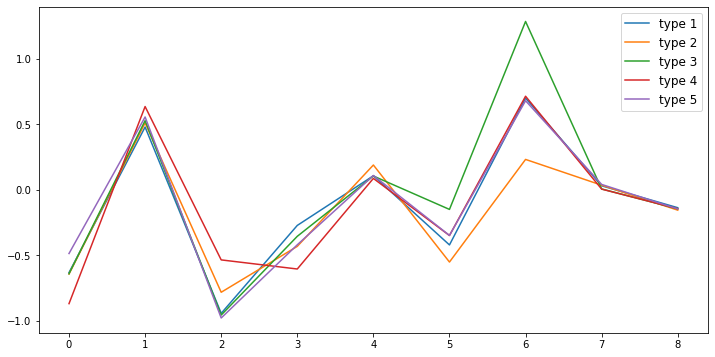

In [13]:
import matplotlib.pyplot as plt
import arviz as az
from scipy.stats import wasserstein_distance
from itertools import combinations

# az.style.use("arviz-darkgrid")
# az.plot_trace(fit)   # "w_bar" [1,1] ~ [5,9] length(9) vector가 5개
# plt.show()

summary_dict = fit.summary()
df = pd.DataFrame(summary_dict['summary'], 
                  columns=summary_dict['summary_colnames'], 
                  index=summary_dict['summary_rownames'])
df

plt.figure(figsize=(12, 6))

w_bar = [0] * len(np.unique(engine_df))
for i in range(5):
    w_bar[i] = [df.loc[f'w_bar[{i + 1},{j}]','mean'] for j in range(1, 10)]
    plt.plot(np.arange(9),w_bar[i], label = f'type {i +1}')
    plt.legend(fontsize = 'large')

w_bar_dist = [[(i,j),wasserstein_distance(w_bar[i], w_bar[j])] for (i,j) in list(combinations(np.arange(5),2))]
w_bar_dist

In [14]:
# pd.DataFrame(w_bar_dist)
sorted(w_bar_dist)
# 0.0425  1,5
# 0.0461  4,5
# 0.0466  1,4
# 0.1057  1,3
# 0.1076  2,5
# 0.1090  1,2
# 0.1237  3,5
# 0.1244  2,4
# 0.1278  3,4
# 0.1836  2,3

[[(0, 1), 0.1116669112064567],
 [(0, 2), 0.09767844578831711],
 [(0, 3), 0.057482588158472535],
 [(0, 4), 0.04198225300265305],
 [(1, 2), 0.20547480842359805],
 [(1, 3), 0.10841348611169453],
 [(1, 4), 0.1285854482823409],
 [(2, 3), 0.13364507131622125],
 [(2, 4), 0.12373770432131273],
 [(3, 4), 0.05755434055720175]]

In [ ]:
alpha = np.array([fit_df[f'alpha[{s+1}]'] for s in range(S)])
w = np.array([[fit_df[f'w[{s+1},{k+1}]'] for k in range(K)] for s in range(S)])
mu = np.tile(np.expand_dims(alpha, 0), (T, 1)) + basis_df.values @ w.transpose()

alpha_bar = np.array([fit_df[f'alpha_bar[{e+1}]'] for e in range(E)])
w_bar = np.array([[fit_df[f'w_bar[{e+1},{k+1}]'] for k in range(K)] for e in range(E)])
mu_bar = np.tile(np.expand_dims(alpha_bar, 0), (T, 1)) + basis_df.values @ w_bar.transpose()

mu_alpha_bar = fit_df['mu_alpha_bar']
mu_w_bar = np.array([fit_df[f'mu_w_bar[{k+1}]'] for k in range(K)])
mu_zero = np.repeat(mu_alpha_bar, failure_df.shape[0]) + basis_df.values @ mu_w_bar

# fig, ax = plt.subplots(figsize=(6, 4))
# ax.set_xlabel('Age(year)')
# ax.set_ylabel('Scaled failure rates')
# ax.scatter(failure_df.index[age_index], Y, color='k', alpha=0.1, s=20)
# ax.plot(np.arange(1, T + 1), mu, color='g', alpha=0.5, linewidth=0.3)
# ax.plot(np.arange(1, T + 1), mu_bar, color='m', alpha=1, linewidth=1.5)
# ax.plot(np.arange(1, T + 1), mu_zero, color='b', alpha=1, linewidth=3)

# plt.savefig('HS_layer3.png', dpi=400)    
# plt.savefig('HS.png', dpi=400)    

# plt.show()

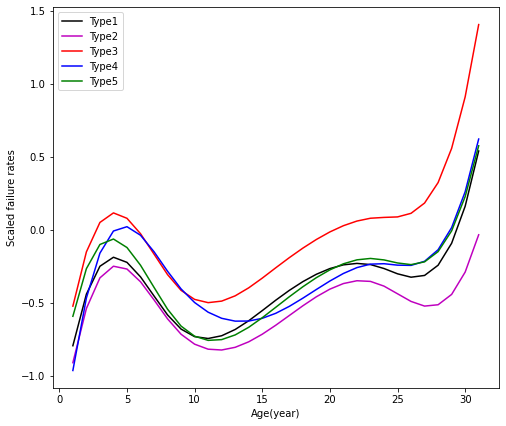

In [16]:
# fig, ax = plt.subplots(figsize=(6, 4))
# ax.set_xlabel('Age')
# ax.set_ylabel('Failures')
# ax.scatter(failure_df.index[age_index], Y, color='k', alpha=0.1, s=20)
# ax.plot(np.arange(1, T + 1), mu, color='g', alpha=0.3, linewidth=0.3)
# ax.plot(np.arange(1, T + 1), mu_bar, color='m', alpha=1, linewidth=1.5)
# ax.plot(np.arange(1, T + 1), mu_zero, color='b', alpha=1, linewidth=3)



fig, ax = plt.subplots(figsize=(8, 7))
# ax.set_facecolor('white')
ax.set_xlabel('Age(year)')
ax.set_ylabel('Scaled failure rates')

line1 = ax.plot(np.arange(1, T + 1), mu_bar.transpose()[0], color='k', alpha=1, linewidth=1.5, label = 'Type1')
line2 = ax.plot(np.arange(1, T + 1), mu_bar.transpose()[1], color='m', alpha=1, linewidth=1.5, label = 'Type2')
line3 = ax.plot(np.arange(1, T + 1), mu_bar.transpose()[2], color='r', alpha=1, linewidth=1.5, label = 'Type3')
line4 = ax.plot(np.arange(1, T + 1), mu_bar.transpose()[3], color='b', alpha=1, linewidth=1.5, label = 'Type4')
line5 = ax.plot(np.arange(1, T + 1), mu_bar.transpose()[4], color='g', alpha=1, linewidth=1.5, label = 'Type5')

plt.legend(loc='upper left')
plt.savefig('euclidian.png', dpi=400)    

plt.show()

In [ ]:
plt.figure(figsize=(12, 6))

w_bar = [0] * len(np.unique(se))
for i in range(5):
    w_bar[i] = [df.loc[f'w_bar[{i + 1},{j}]','mean'] for j in range(1, 10)]
    plt.plot(np.arange(9),w_bar[i], label = f'type {i +1}')
    plt.legend(fontsize = 'large')

w_bar_dist = [[(i,j),wasserstein_distance(w_bar[i], w_bar[j])] for (i,j) in list(combinations(np.arange(5),2))]
w_bar_dist

In [ ]:
# hs train ship
hs_train_rmse = []
for i in range(0,99):
    comp = pd.concat([pd.DataFrame(mu).iloc[:,i], failure_df.iloc[:,i]], axis=1).dropna()
    hs_train_rmse.append(RMSE(comp.iloc[:,0], comp.iloc[:,1]))
np.mean(hs_train_rmse)

In [ ]:
# hs train type
print('HS train type')
y_bar_rmse = []
for j in range(1, 6):
    ships = engine_df.index[engine_df['engine'] == j]
    temp = []
    for i in range(0, failure_df[ships].shape[1]):
#         if len(failure_df[ships].iloc[:,i].dropna()) > 3 :
            comp = pd.concat([pd.DataFrame(mu_bar).iloc[:,j-1], failure_df[ships].iloc[:,i]], axis=1).dropna()
            y_bar_rmse.append(RMSE(comp.iloc[:,0], comp.iloc[:,1]))
            temp.append(RMSE(comp.iloc[:,0], comp.iloc[:,1]))
    print(j,  np.mean(temp))
print('')
print(np.mean(y_bar_rmse))
        
    


In [ ]:

def predict_prophet(s):
    ds = pd.date_range('2020-01-01', periods=s.shape[0], freq='12M')
    training_df = pd.DataFrame({'ds': ds, 'y': s})
    m = Prophet()
    m.fit(training_df)
    predict_df = pd.DataFrame({'ds': ds})
    return m.predict(predict_df)['yhat']

y_bar_prophet = []
for i in range(1, 6):
    ships = engine_df.index[engine_df['engine'] == i]
    y_bar_prophet.append(predict_prophet(failure_df[ships].mean(axis=1).values))
#     print(RMSE(y_bar_prophet, failure_df[ships]))
#     print(failure_df[ships].values)
    
y_bar_prophet = np.array(y_bar_prophet).transpose()

y_zero_prophet = predict_prophet(failure_df.mean(axis=1).values)

fig, ax = plt.subplots(figsize=(6, 4))
ax.set_xlabel('Age(year)')
ax.set_ylabel('Scaled failure rates')
ax.scatter(failure_df.index[age_index], Y, color='k', alpha=0.2, s=20)
# ax.plot(np.arange(1, T + 1), y_bar_prophet, color='m', alpha=1, linewidth=1.5)
ax.plot(np.arange(1, T + 1), y_zero_prophet, color='b', alpha=1, linewidth=3)

# plt.savefig('prophet.png', dpi=400)    

plt.show()

In [ ]:
# prophet train ship

import warnings
warnings.filterwarnings('ignore')

def predict_prophet(s):
    ds = pd.date_range('2020-01-01', periods=s.shape[0], freq='12M')
    training_df = pd.DataFrame({'ds': ds, 'y': s})
    m = Prophet()
    m.fit(training_df)
    predict_df = pd.DataFrame({'ds': ds})
    return m.predict(predict_df)['yhat']

y_rmse = []
y_prophet = []
for i in range(0, failure_df.shape[1]) :
    if len(failure_df.iloc[:,i].dropna()) > 1 :
        y_prophet.append(predict_prophet(failure_df.iloc[:,i]))
        comp = pd.concat([y_prophet[i], failure_df.iloc[:,i]], axis = 1).dropna()
        y_rmse.append(RMSE(comp.iloc[:,0], comp.iloc[:,1]))
    else :
        y_prophet.append(0)

print(np.mean(y_rmse))


# fig, ax = plt.subplots(figsize=(12, 6))
# ax.set_xlabel('age')
# ax.set_ylabel('failures')
# ax.scatter(failure_df.index[age_index], Y, color='k', alpha=0.1)
# ax.plot(np.arange(1, T + 1), y_prophet, color='m', alpha=1, linewidth=1.5)
# plt.show()

In [ ]:
# prophet train type

train_prophet_rmse =[]
temp = []
print('prophet train type')
for j in range(1, 6):
    ships = engine_df.index[engine_df['engine'] == j]
    for i in range(0, failure_df[ships].shape[1]):
        if len(failure_df[ships].iloc[:,i].dropna()) > 4:
            comp = pd.concat([pd.DataFrame(y_bar_prophet.transpose()[j - 1]),
                              failure_df[ships].iloc[:,i]], axis=1).dropna()
            train_prophet_rmse.append(RMSE(comp.iloc[:,0], comp.iloc[:,1]))
            temp.append(RMSE(comp.iloc[:,0], comp.iloc[:,1]))
    print(j, np.mean(temp))    
np.mean(train_prophet_rmse)



In [ ]:
def predict_arima(s):
    pn = len(list(itertools.takewhile(np.isnan, s)))
    tn = len(list(itertools.takewhile(np.isnan, s[::-1])))
    if tn:
        m = pm.auto_arima(s[pn:-tn])
        return np.concatenate(
            (np.full(pn, np.nan)),
            m.predict_in_sample(),
            m.predict(tn),
        )
    else:
        m = pm.auto_arima(s[pn:])
        return np.concatenate((
            np.full(pn, np.nan),
            m.predict_in_sample(),
        ))

def pred_arima(s):
    m1 = pm.auto_arima(s,error_action='ignore', seasonal=True, m=2)
    y_bar_arima=pd.DataFrame(m1.predict(n_periods=s.shape[0]))
    return y_bar_arima    

def pred2_arima(s):
    m1 = pm.auto_arima(s,error_action='ignore', seasonal=True, m=1)
    y_bar_arima=pd.DataFrame(m1.predict(n_periods=s.shape[0]))
    return y_bar_arima        
    
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n


y_zero_arima = predict_arima(failure_df.mean(axis=1).values)

y_bar_arima = []
for i in range(1, 6):
    ships = engine_df.index[engine_df['engine'] == i]
    try:
        y_bar_arima.append(predict_arima(failure_df[ships].mean(axis=1).values))
    except:
        y_bar_arima.append(y_zero_arima)
y_bar_arima = np.array(y_bar_arima).transpose()

fig, ax = plt.subplots(figsize=(6, 4))
ax.set_xlabel('Age(year)')
ax.set_ylabel('Scaled failure rates')
ax.scatter(failure_df.index[age_index], Y, color='k', alpha=0.2, s=20)
# ax.plot(np.arange(1, T + 1), y_bar_arima, color='m', alpha=1, linewidth=1.5)
ax.plot(np.arange(1, T + 1), y_zero_arima, color='b', alpha=1, linewidth=3)


# plt.savefig('arima.png', dpi=400)    

plt.show()

In [ ]:
def predict_arima(s):
    pn = len(list(itertools.takewhile(np.isnan, s)))
    tn = len(list(itertools.takewhile(np.isnan, s[::-1])))
    if tn:
        m = pm.auto_arima(s[pn:-tn])
        return np.concatenate(
            (np.full(pn, np.nan)),
            m.predict_in_sample(),
            m.predict(tn),
        )
    else:
        m = pm.auto_arima(s[pn:])
        return np.concatenate((
            np.full(pn, np.nan),
            m.predict_in_sample(),
        ))
    
def pred_arima(s):
    m1 = pm.auto_arima(s,error_action='ignore', seasonal=True, m=2)
    y_bar_arima=pd.DataFrame(m1.predict(n_periods=s.shape[0]))
    return y_bar_arima    

def pred2_arima(s):
    m1 = pm.auto_arima(s,error_action='ignore', seasonal=True, m=1)
    y_bar_arima=pd.DataFrame(m1.predict(n_periods=s.shape[0]))
    return y_bar_arima    
    
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

y_zero_arima = predict_arima(failure_df.mean(axis=1).values)


y_bar_arima = []

fig, ax = plt.subplots(figsize=(12, 6))
ax.set_xlabel('age')
ax.set_ylabel('failures')
ax.scatter(failure_df.index[age_index], Y, color='k', alpha=0.1)

# for i in range(1, 6):
#     ships = engine_df.index[engine_df['engine'] == i]
#     keys=failure_df[ships].mean(axis=1).dropna().reset_index().age
#     if i < 5 :
#         y_bar_arima.append(pred_arima(failure_df[ships].mean(axis=1).dropna()))
#         plt.plot(pd.concat([failure_df[ships].mean(axis=1).dropna(), pd.DataFrame(y_bar_arima[i-1]).set_index(keys)], axis=1).iloc[:,1])
#     else : 
#         y_bar_arima.append(pred2_arima(failure_df[ships].mean(axis=1).dropna()))
#         plt.plot(pd.concat([failure_df[ships].mean(axis=1).dropna(), pd.DataFrame(y_bar_arima[i-1]).set_index(keys)], axis=1).iloc[:,1])

plt.plot(y_zero_arima)

ships = engine_df.index[engine_df['engine'] == 1]
keys=failure_df[ships].mean(axis=1).dropna().reset_index().age
m1 = pm.auto_arima(failure_df[ships].mean(axis=1).dropna(),error_action='ignore', seasonal=True, m=2)
y_bar_arima.append(pd.DataFrame(m1.predict(n_periods=failure_df[ships].mean(axis=1).dropna().shape[0])))
plt.plot(pd.concat([failure_df[ships].mean(axis=1).dropna(), 
                    (y_bar_arima[0]).set_index(keys)], axis=1).iloc[:,1], color='m', alpha=1, linewidth=1.5)

ships = engine_df.index[engine_df['engine'] == 2]
keys=failure_df[ships].mean(axis=1).dropna().reset_index().age
m1 = pm.auto_arima(failure_df[ships].mean(axis=1).dropna(),error_action='ignore', seasonal=True, m=2)
y_bar_arima.append(pd.DataFrame(m1.predict(n_periods=failure_df[ships].mean(axis=1).dropna().shape[0])))
plt.plot(pd.concat([failure_df[ships].mean(axis=1).dropna(), 
                    (y_bar_arima[1]).set_index(keys)], axis=1).iloc[:,1], color='m', alpha=1, linewidth=1.5)

ships = engine_df.index[engine_df['engine'] == 3]
keys=failure_df[ships].mean(axis=1).dropna().reset_index().age
m1 = pm.auto_arima(failure_df[ships].mean(axis=1).dropna(),error_action='ignore', seasonal=True, m=2)
y_bar_arima.append(pd.DataFrame(m1.predict(n_periods=failure_df[ships].mean(axis=1).dropna().shape[0])))
plt.plot(pd.concat([failure_df[ships].mean(axis=1).dropna(), 
                    (y_bar_arima[2]).set_index(keys)], axis=1).iloc[:,1], color='m', alpha=1, linewidth=1.5)

ships = engine_df.index[engine_df['engine'] == 4]
keys=failure_df[ships].mean(axis=1).dropna().reset_index().age
m1 = pm.auto_arima(failure_df[ships].mean(axis=1).dropna(),error_action='ignore', seasonal=True, m=2)
y_bar_arima.append(pd.DataFrame(m1.predict(n_periods=failure_df[ships].mean(axis=1).dropna().shape[0])))
plt.plot(pd.concat([failure_df[ships].mean(axis=1).dropna(), 
                    (y_bar_arima[3]).set_index(keys)], axis=1).iloc[:,1], color='m', alpha=1, linewidth=1.5)



# ax.plot(np.arange(1, 6), y_bar_arima, color='m', alpha=1, linewidth=1.5)
# ax.plot(np.arange(1, T + 1), y_zero_arima, color='b', alpha=1, linewidth=3)
plt.show()

In [ ]:
y = failure_df[ships].mean(axis=1).dropna()
modl = pm.auto_arima(y, start_p=1, start_q=1, start_P=1, start_Q=1,
                     max_p=5, max_q=5, max_P=5, max_Q=5, seasonal=True,
                     stepwise=True, suppress_warnings=True, D=10, max_D=10,
                     error_action='ignore')
preds, conf_int = modl.predict(n_periods=y.shape[0], return_conf_int=True)
preds

In [ ]:
# auto arima
ships = engine_df.index[engine_df['engine'] == 5]
failure_df[ships].mean(axis=1).dropna()
m1 = pm.auto_arima(failure_df[ships].mean(axis=1).dropna(), 
                   error_action='ignore', seasonal=True, m=1)
y_bar_arima=pd.DataFrame(m1.predict(n_periods=failure_df[ships].mean(axis=1).dropna().shape[0]))
y_bar_arima


In [ ]:
# arima train ship

import warnings
warnings.filterwarnings('ignore')


def predict_arima(s):
    pn = len(list(itertools.takewhile(np.isnan, s)))
    tn = len(list(itertools.takewhile(np.isnan, s[::-1])))
    if tn:
        m = pm.auto_arima(s[pn:-tn])
        return np.concatenate(
            (np.full(pn, np.nan)),
            m.predict_in_sample(),
            m.predict(tn),
        )
    else:
        m = pm.auto_arima(s[pn:])
        return np.concatenate((
            np.full(pn, np.nan),
            m.predict_in_sample(),
        ))

# arima train ship

arima_rmse=[]
for i in range(1, failure_df.shape[1]):
    if len(failure_df.iloc[:,i].dropna()) > 4 :
        y_arima = predict_arima(np.array(failure_df.iloc[:,i].dropna()))
#         print(i)
        arima_rmse.append(RMSE(y_arima, np.array(failure_df.iloc[:,i].dropna())))
np.mean(arima_rmse)

In [ ]:
# arima train type

train_arima_rmse =[]
print('ARIMA train type')
for j in range(1, 6):
    ships = engine_df.index[engine_df['engine'] == j]
    temp = []
    for i in range(0, failure_df[ships].shape[1]):
        if len(failure_df[ships].iloc[:,i].dropna()) > 5:
            comp = pd.concat([pd.DataFrame(y_bar_arima.transpose()[j - 1]),
                              failure_df[ships].iloc[:,i]], axis=1).dropna()
            train_arima_rmse.append(RMSE(comp.iloc[:,0], comp.iloc[:,1]))
            temp.append(RMSE(comp.iloc[:,0], comp.iloc[:,1]))
    print(j, np.mean(temp))    
np.mean(train_arima_rmse)

In [ ]:
rmse_hs = []
rmse_prophet = []
rmse_arima = []
smape_hs = []
smape_prophet = []
smape_arima = []
for e in range(1, 6):
    test_ships = test_engine_df.index[test_engine_df['engine'] == e]
    test_Y = test_failure_df[test_ships].values[~test_failure_df[test_ships].isnull()]
    test_age_index, test_ship_index = np.where(~test_failure_df[test_ships].isnull())
    
    rmse_hs.append(RMSE(test_Y, mu_bar[test_age_index, e - 1]))
    rmse_prophet.append(RMSE(test_Y, y_bar_prophet[test_age_index, e - 1]))
    rmse_arima.append(RMSE(test_Y, y_bar_arima[test_age_index, e - 1]))
print(rmse_hs)
print(rmse_prophet)
print(rmse_arima)
#     smape_hs.append(SMAPE(test_Y, mu_bar[test_age_index, e - 1]))
#     smape_prophet.append(SMAPE(test_Y, y_bar_prophet[test_age_index, e - 1]))
#     smape_arima.append(SMAPE(test_Y, y_bar_arima[test_age_index, e - 1]))
    

    
    
fig, ax = plt.subplots(figsize=(8, 4))
print(pd.DataFrame({'engine': range(1, 6),
              'rmse_hs': rmse_hs,
              'rmse_prophet': rmse_prophet,
              'rmse_arima': rmse_arima}))

pd.DataFrame({'engine': range(1, 6),
              'rmse_hs': rmse_hs,
              'rmse_prophet': rmse_prophet,
              'rmse_arima': rmse_arima}).set_index('engine').plot.bar(ax=ax)


# fig, ax = plt.subplots(figsize=(12, 4))
# print(pd.DataFrame({'engine': range(1, 6),
#               'smape_hs': smape_hs,
#               'smape_prophet': smape_prophet,
#               'smape_arima': smape_arima}))

# pd.DataFrame({'engine': range(1, 6),
#               'smape_hs': smape_hs,
#               'smape_prophet': smape_prophet,
#               'smape_arima': smape_arima}).set_index('engine').plot.bar(ax=ax)

# fig, ax = plt.subplots(figsize=(12, 6))
# ax.set_xlabel('ship')
# ax.set_ylabel('age')
# ax.matshow(failure_df)
# # plt.show()

In [ ]:
rmse_hs = []
rmse_prophet = []
rmse_arima = []
smape_hs = []
smape_prophet = []
smape_arima = []
for e in range(6, 11):
    test_ships = test_engine_df.index[test_engine_df['engine'] == e]
    test_Y = test_failure_df[test_ships].values[~test_failure_df[test_ships].isnull()]
    test_age_index, test_ship_index = np.where(~test_failure_df[test_ships].isnull())
    rmse_hs.append(RMSE(test_Y, mu_zero[test_age_index]))
    rmse_prophet.append(RMSE(test_Y, y_zero_prophet[test_age_index]))
    rmse_arima.append(RMSE(test_Y, y_zero_arima[test_age_index]))

    
fig, ax = plt.subplots(figsize=(8, 4))
print(pd.DataFrame({'engine': range(6, 11),
              'rmse_hs': rmse_hs,
              'rmse_prophet': rmse_prophet,
              'rmse_arima': rmse_arima}))
pd.DataFrame({'engine': range(6, 11),
              'rmse_hs': rmse_hs,
              'rmse_prophet': rmse_prophet,
              'rmse_arima': rmse_arima}).set_index('engine').plot.bar(ax=ax)


print(np.mean(rmse_hs))
print(np.mean(rmse_prophet))
print(np.mean(rmse_arima))

# fig, ax = plt.subplots(figsize=(12, 4))
# print(pd.DataFrame({'engine': range(6, 11),
#               'smape_hs': smape_hs,
#               'smape_prophet': smape_prophet,
#               'smape_arima': smape_arima}))

# pd.DataFrame({'engine': range(6, 11),
#               'smape_hs': smape_hs,
#               'smape_prophet': smape_prophet,
#               'smape_arima': smape_arima}).set_index('engine').plot.bar(ax=ax)

In [171]:
y_data = pd.DataFrame(Y)
y_data.columns = ['y']
y_data

,y
0,-1.824749
1,-1.000000
2,-1.597742
3,-1.415051
4,-1.351330
...,...
648,0.702004
649,1.039004
650,1.019047
651,1.000000


In [172]:
import os
import pystan

In [162]:
stan_file = os.path.join('./models','simulate_ensemble.stan')
FF_model = pystan.StanModel(file=stan_file)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_96794ef6a24098374c12577fbc153ef8 NOW.


In [174]:
R = 1000
N = 1000
sample_k = 17;  # 17이 의미하는게 뭐지
simul_data = {
    "K": basis_df.shape[1],
    "N" : N,
    "N_obs" : y_data["y"].values.shape[0],
    "T" : 31,
    "B" : basis_df.values.tolist(),
    "K_i" : sample_k,
    "y_data": y_data["y"].values.tolist(),
}
FF_fit = FF_model.sampling(iter=R, algorithm="Fixed_param", chains=1, data=simul_data) #compile_model(layer3_path))


In [175]:
FF_samples = {}
for key in ["s_a", "s_w", "s_a_bar", "s_w_bar", "mu_a_bar"]:
    FF_samples[key] = FF_fit.extract(pars=[f"{key}"])[f"{key}"]
FF_samples["y"] = FF_fit.extract(pars=["sim_y"])["sim_y"]

In [176]:
sim_w_bar = FF_fit.extract(pars=["mu_w_bar"])["mu_w_bar"]
# R = number of iterations, N = number of samples per iterations
# extracted sample array would be of shape (R, N, (dim(V) if vector))
for x in range(sim_w_bar.shape[1]): 
    FF_samples[f"mu_w_bar[{x+1}]"] = sim_w_bar[:, x]

In [177]:
for key, val in FF_samples.items():
    print(key, val.shape)

s_a (1000,)
s_w (1000,)
s_a_bar (1000,)
s_w_bar (1000,)
mu_a_bar (1000,)
y (1000, 1000)
mu_w_bar[1] (1000,)
mu_w_bar[2] (1000,)
mu_w_bar[3] (1000,)
mu_w_bar[4] (1000,)
mu_w_bar[5] (1000,)
mu_w_bar[6] (1000,)
mu_w_bar[7] (1000,)
mu_w_bar[8] (1000,)
mu_w_bar[9] (1000,)
mu_w_bar[10] (1000,)
mu_w_bar[11] (1000,)


In [178]:
inferential_params = ["y", "s_a", "s_w", "s_a_bar", "s_w_bar", "mu_a_bar"] + [f"mu_w_bar[{x+1}]" for x in range(sim_w_bar.shape[1])]

In [179]:
inferential_params

['y',
 's_a',
 's_w',
 's_a_bar',
 's_w_bar',
 'mu_a_bar',
 'mu_w_bar[1]',
 'mu_w_bar[2]',
 'mu_w_bar[3]',
 'mu_w_bar[4]',
 'mu_w_bar[5]',
 'mu_w_bar[6]',
 'mu_w_bar[7]',
 'mu_w_bar[8]',
 'mu_w_bar[9]',
 'mu_w_bar[10]',
 'mu_w_bar[11]']

## Fit simulated ensemble

In [180]:
fit_data_file = os.path.join('./models','fit_data.stan')
comp_model = pystan.StanModel(file=fit_data_file)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_5504f5b80e8d7d2cb2d788800159769b NOW.


In [183]:
post_zscores = {x: [] for x in inferential_params}
post_contraction_scores = {x: [] for x in inferential_params}
processes = 6  # number of PHYSICAL cores on system for maximum performance
splitted_simul_samples = [{} for x in range(processes)]
for param in inferential_params:
    batches = np.array_split(FF_samples[param], processes)
    i = 0
    for s in splitted_simul_samples:
        s[param] = batches[i]
        i += 1

In [184]:
%%time
extracted_params = ["s_a", "s_w", "s_a_bar", "s_w_bar", "mu_a_bar", "mu_w_bar"]
def fit_parallel(samples, process_index):
    post_mean_scores = {k: [] for k in samples.keys()}
    post_sd_scores = {k: [] for k in samples.keys()}
    for i in range(samples["y"].shape[0]):  # iterate over number of chains
        fit_sample_k = sample_k;
        
        fit_comp_data = {
            "K": basis_df.shape[1],
            "N" : N,
            "T" : 31,
            "B" : basis_df.values.tolist(),
            "K_i" : fit_sample_k,
            "y" : samples["y"][i].tolist(),  # use np.mean?
            "N_obs" : y_data["y"].values.shape[0],
            "y_obs": y_data["y"].values.tolist(),
        }
        
        comp_fit = comp_model.sampling(data=fit_comp_data, chains=1, iter=2000, n_jobs=1)
        summary_data = comp_fit.summary(pars=extracted_params)["summary"]
        for index, param in enumerate([x for x in inferential_params if x != "y"]):
            post_mean_scores[param].append(summary_data[index][0])
            post_sd_scores[param].append(summary_data[index][2])
            
        post_y_samples = comp_fit.extract(pars=["post_y"])["post_y"].flatten()
        post_mean_scores["y"].append(np.mean(post_y_samples))
        post_sd_scores["y"].append(np.std(post_y_samples))

    return (post_mean_scores, post_sd_scores, process_index)

pooled_post_mean_scores = {x: [] for x in inferential_params}
pooled_post_sd_scores = {x: [] for x in inferential_params}
process_results = []
import multiprocessing
with multiprocessing.Pool(processes=processes) as pool:
    results = [pool.apply_async(fit_parallel, (batch, index)) for  index, batch in enumerate(splitted_simul_samples)]
    
    for r in results:
        payload = r.get()
        process_results.append(payload)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run a

To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run a

To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run a

To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run a

To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run a

To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run a

To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run a

To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run a

To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run a

To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run a

To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run a

To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run a

To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run a

To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run a

To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run a

To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run a

To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run a

To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run a

To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run a

To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run a

To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run a

To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run a

To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run a

To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run a

To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run a

To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run a

To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run a

To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run a

To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run a

To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run a

To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run a

To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run a

To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run a

To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run a

To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run a

To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run a

To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run a

To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run a

To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run a

To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run a

To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run a

To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run a

CPU times: user 2.18 s, sys: 1.27 s, total: 3.45 s
Wall time: 1h 7min 56s


In [185]:
process_results = sorted(process_results, key=lambda x: x[2])
for param in inferential_params:
    for x in range(processes):
        pooled_post_mean_scores[param].extend(process_results[x][0][param])
        pooled_post_sd_scores[param].extend(process_results[x][1][param])

    pooled_post_mean_scores[param] = np.array(pooled_post_mean_scores[param])
    pooled_post_sd_scores[param] = np.array(pooled_post_sd_scores[param])

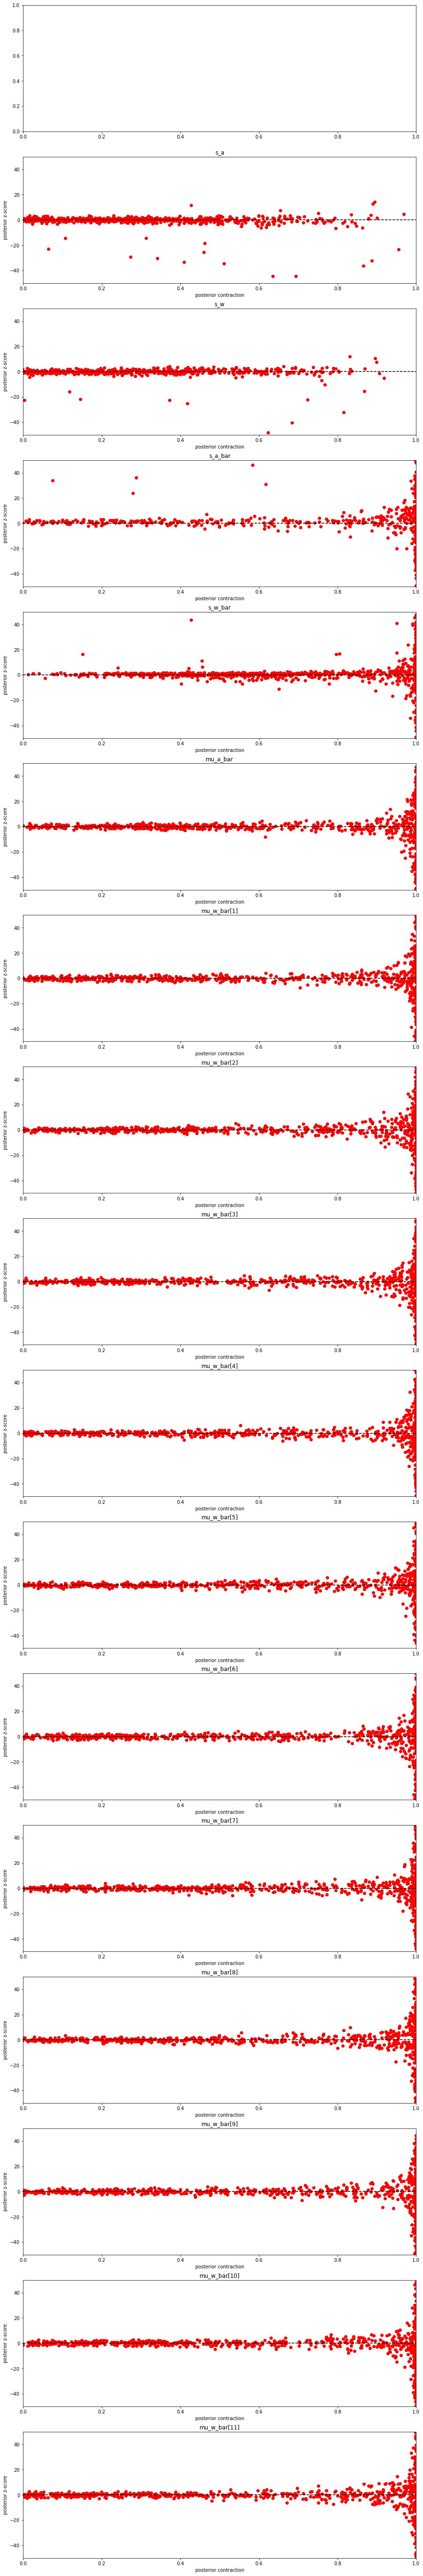

In [188]:
fig, ax = plt.subplots(len(inferential_params), figsize=(15,100))
for i, param in enumerate(inferential_params):
    if param == "y":
        continue
    prior_sd = np.std(FF_samples[param], ddof=1)
    zscore = (pooled_post_mean_scores[param] - FF_samples[param]) / pooled_post_sd_scores[param]
    contraction = 1 - (pooled_post_sd_scores[param] / prior_sd) ** 2
    ax[i].set_title(param)
    ax[i].set_xlim(0, 1)
    ax[i].set_ylim(-50, 50)
    ax[i].axhline(0, linestyle="--", c="black")
    ax[i].set_xlabel("posterior contraction")
    ax[i].set_ylabel("posterior z-score")
    ax[i].scatter(contraction, zscore, c="r")

## Verdict: Poorly identified

The likelihood functions tend to disperse over expansive regions of the model configuration space for most, if not all, observations.

In [193]:
fit_comp_data = {
            "K": basis_df.shape[1],
            "N" : 1000,
            "T" : 31,
            "B" : basis_df.values.tolist(),
            "K_i" : 15,
            "y" : FF_samples["y"][500].tolist(),  # use np.mean?
            "N_obs" : y_data["y"].values.shape[0],
            "y_obs": y_data["y"].values.tolist(),
        }
        
fit_comp_fit = comp_model.sampling(data=fit_comp_data, chains=4, iter=2000)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [194]:
ifd = az.from_pystan(posterior=fit_comp_fit, posterior_predictive="post_y", observed_data="y_obs")

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f83d9b98690>],
      dtype=object)

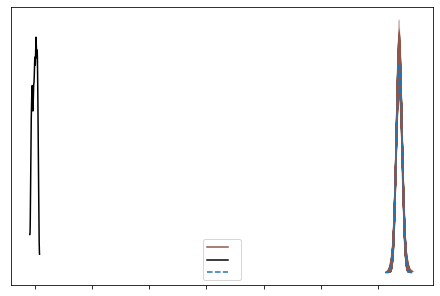

In [195]:
az.plot_ppc(ifd, data_pairs={"y_obs": "post_y"})